# Assignment 2: Affect Recognition from Landmarks

**Group 2** : Abhinav Ramalingam & Victoria Van Rillaer

In [1]:
%pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

## Preprocessing

In [20]:
train_data = pd.read_csv("dataset.csv")
test_data = pd.read_csv("test_to_submit.csv")

X = train_data.drop(columns=['emotion'])  
y = pd.get_dummies(train_data['emotion'])  

scaler = StandardScaler()
X = scaler.fit_transform(X)
test_to_submit = scaler.transform(test_data)  

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=train_data['emotion'], random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp.idxmax(axis=1), random_state=42)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}") 
print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")


X_train shape: (812, 20)
y_train shape: (812, 7)
X_val shape: (174, 20)
y_val shape: (174, 7)


## Selection of the model

### Basic Machine Learning models

In [21]:
y_train_decoded = y_train.idxmax(axis=1)
y_test_decoded = y_test.idxmax(axis=1)

models = {
    "Random Forest": RandomForestClassifier(random_state=42, class_weight='balanced'),
    "Support Vector Machine": SVC(kernel='linear', random_state=42, class_weight='balanced'),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=7),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42)
}

results = []

with open("model_results.txt", "a") as file:
    for model_name, model in models.items():
        model.fit(X_train, y_train_decoded)
        y_pred = model.predict(X_test)
        
        accuracy = accuracy_score(y_test_decoded, y_pred)
        
        result = {
            "Model": model_name,
            "Parameters": model.get_params(),
            "Accuracy": accuracy
        }
        results.append(result)
        
        file.write(f"Model: {model_name}\n")
        file.write(f"Parameters: {result['Parameters']}\n")
        file.write(f"Accuracy: {accuracy:.4f}\n")
        file.write("="*40 + "\n")

results_df = pd.DataFrame(results)
print(results_df)


                    Model                                         Parameters  \
0           Random Forest  {'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...   
1  Support Vector Machine  {'C': 1.0, 'break_ties': False, 'cache_size': ...   
2     K-Nearest Neighbors  {'algorithm': 'auto', 'leaf_size': 30, 'metric...   
3       Gradient Boosting  {'ccp_alpha': 0.0, 'criterion': 'friedman_mse'...   

   Accuracy  
0  0.600000  
1  0.542857  
2  0.582857  
3  0.600000  


### MLP model

In [22]:
model = Sequential()

model.add(Dense(64, input_dim=X_train.shape[1], activation='relu')) 
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu')) 
model.add(Dense(y_train.shape[1], activation='softmax')) 

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

/Users/abhinavramalingam/Documents/Uppsala/IID/.conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 64)             │         1,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 7)              │           119 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,071 (15.90 KB)

 Trainable params: 4,071 (15.90 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
# Early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, 
                    validation_data=(X_val, y_val), 
                    callbacks=[early_stopping])

Epoch 1/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2246 - loss: 1.8597 - val_accuracy: 0.4828 - val_loss: 1.6469
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 878us/step - accuracy: 0.5129 - loss: 1.5960 - val_accuracy: 0.5747 - val_loss: 1.3726
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6055 - loss: 1.2940 - val_accuracy: 0.5920 - val_loss: 1.2398
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6180 - loss: 1.1972 - val_accuracy: 0.6149 - val_loss: 1.1814
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step - accuracy: 0.5953 - loss: 1.1688 - val_accuracy: 0.6092 - val_loss: 1.1444
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 931us/step - accuracy: 0.6415 - loss: 1.0371 - val_accuracy: 0.6322 - val_loss: 1.1310
Epoch 7/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/step - accuracy: 0.6188 - loss: 1.0443 - val_accuracy: 0.6092 - val_loss: 1.1078
Epoch 8/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step - accuracy: 0.6368 - loss: 1.0146 - val_accuracy: 

## Hyperparameters tuning

In [29]:
neurons = [32, 48, 64, 128]  
hidden_layer_options = [1, 2, 3] 
best_accuracy = 0
accuracies = []

for num_layers in hidden_layer_options:
    for neuron in neurons:
       
        model = Sequential()
        model.add(Dense(neuron, input_dim=X_train.shape[1], activation='relu'))  
        for _ in range(num_layers - 1):  
            model.add(Dense(neuron // 2, activation='relu'))
        model.add(Dense(y_train.shape[1], activation='softmax')) 
        
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        

        history = model.fit(X_train, y_train, epochs=50, batch_size=32, 
                            validation_data=(X_val, y_val), callbacks=[early_stopping])
        

        _, accuracy = model.evaluate(X_test, y_test)
        accuracies.append((num_layers, neuron, accuracy))  

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_model = model


accuracies_np = np.array(accuracies)
neurons_list = accuracies_np[:, 1] 
accuracies_per_layers = {layer: [] for layer in hidden_layer_options}

for (num_layers, neuron, accuracy) in accuracies:
    accuracies_per_layers[num_layers].append((neuron, accuracy))

Epoch 1/50


/Users/abhinavramalingam/Documents/Uppsala/IID/.conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1784 - loss: 2.1303 - val_accuracy: 0.3046 - val_loss: 1.8355
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 784us/step - accuracy: 0.3074 - loss: 1.8285 - val_accuracy: 0.4655 - val_loss: 1.6075
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step - accuracy: 0.4653 - loss: 1.6077 - val_accuracy: 0.5862 - val_loss: 1.4393
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step - accuracy: 0.5466 - loss: 1.4402 - val_accuracy: 0.5805 - val_loss: 1.3328
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step - accuracy: 0.5870 - loss: 1.3440 - val_accuracy: 0.5920 - val_loss: 1.2682
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step - accuracy: 0.6043 - loss: 1.2410 - val_accuracy: 0.5977 - val_loss: 1.2287
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step - accuracy: 0.5844 - loss: 1.2400 - val_accuracy: 0.5977 - val_loss: 1.2038
Epoch 8/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step - accuracy: 0.5880 - loss: 1.1834 - val_accuracy: 0.6034 - val_lo

/Users/abhinavramalingam/Documents/Uppsala/IID/.conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1373 - loss: 2.0265 - val_accuracy: 0.3966 - val_loss: 1.6712
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step - accuracy: 0.3870 - loss: 1.6338 - val_accuracy: 0.5402 - val_loss: 1.4311
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step - accuracy: 0.5202 - loss: 1.4126 - val_accuracy: 0.5690 - val_loss: 1.3114
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step - accuracy: 0.5457 - loss: 1.2803 - val_accuracy: 0.5575 - val_loss: 1.2505
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step - accuracy: 0.5752 - loss: 1.2043 - val_accuracy: 0.5805 - val_loss: 1.2139
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5873 - loss: 1.1496 - val_accuracy: 0.5747 - val_loss: 1.1900
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step - accuracy: 0.5719 - loss: 1.1523 - val_accuracy: 0.5920 - val_loss: 1.1664
Epoch 8/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step - accuracy: 0.5710 - loss: 1.1581 - val_accuracy: 0.5862 - val_loss

/Users/abhinavramalingam/Documents/Uppsala/IID/.conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1469 - loss: 2.1316 - val_accuracy: 0.4598 - val_loss: 1.6772
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 870us/step - accuracy: 0.4400 - loss: 1.6359 - val_accuracy: 0.5460 - val_loss: 1.3887
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 759us/step - accuracy: 0.5038 - loss: 1.3809 - val_accuracy: 0.5632 - val_loss: 1.2690
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 835us/step - accuracy: 0.5244 - loss: 1.2771 - val_accuracy: 0.5805 - val_loss: 1.2134
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 837us/step - accuracy: 0.5932 - loss: 1.1976 - val_accuracy: 0.5920 - val_loss: 1.1781
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step - accuracy: 0.5779 - loss: 1.1840 - val_accuracy: 0.5747 - val_loss: 1.1558
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step - accuracy: 0.6050 - loss: 1.0986 - val_accuracy: 0.5805 - val_loss: 1.1409
Epoch 8/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step - accuracy: 0.5966 - loss: 1.1021 - val_accuracy: 0.5977 - val_lo

/Users/abhinavramalingam/Documents/Uppsala/IID/.conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2956 - loss: 1.8190 - val_accuracy: 0.5287 - val_loss: 1.3756
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step - accuracy: 0.5287 - loss: 1.3419 - val_accuracy: 0.5805 - val_loss: 1.2091
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step - accuracy: 0.5916 - loss: 1.1557 - val_accuracy: 0.5920 - val_loss: 1.1482
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step - accuracy: 0.5975 - loss: 1.1063 - val_accuracy: 0.6034 - val_loss: 1.1167
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step - accuracy: 0.6075 - loss: 1.0630 - val_accuracy: 0.6092 - val_loss: 1.0957
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step - accuracy: 0.6057 - loss: 1.0452 - val_accuracy: 0.6149 - val_loss: 1.0815
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step - accuracy: 0.6170 - loss: 1.0078 - val_accuracy: 0.6264 - val_loss: 1.0724
Epoch 8/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 687us/step - accuracy: 0.6556 - loss: 0.9547 - val_accuracy: 0.6092 - val_lo

/Users/abhinavramalingam/Documents/Uppsala/IID/.conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1118 - loss: 2.0760 - val_accuracy: 0.2529 - val_loss: 1.8518
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step - accuracy: 0.3303 - loss: 1.7857 - val_accuracy: 0.4540 - val_loss: 1.6150
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step - accuracy: 0.4408 - loss: 1.5747 - val_accuracy: 0.5172 - val_loss: 1.4541
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5209 - loss: 1.4296 - val_accuracy: 0.5632 - val_loss: 1.3567
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step - accuracy: 0.5417 - loss: 1.3335 - val_accuracy: 0.5690 - val_loss: 1.2888
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6058 - loss: 1.2400 - val_accuracy: 0.5690 - val_loss: 1.2341
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 872us/step - accuracy: 0.6002 - loss: 1.1858 - val_accuracy: 0.5747 - val_loss: 1.1973
Epoch 8/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 932us/step - accuracy: 0.6044 - loss: 1.1306 - val_accuracy: 0.5632 - val_loss: 

/Users/abhinavramalingam/Documents/Uppsala/IID/.conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1506 - loss: 2.0617 - val_accuracy: 0.4253 - val_loss: 1.7010
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step - accuracy: 0.4483 - loss: 1.6631 - val_accuracy: 0.5862 - val_loss: 1.4629
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step - accuracy: 0.5923 - loss: 1.4419 - val_accuracy: 0.6034 - val_loss: 1.3125
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step - accuracy: 0.5793 - loss: 1.3108 - val_accuracy: 0.6149 - val_loss: 1.2315
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step - accuracy: 0.6086 - loss: 1.1980 - val_accuracy: 0.6207 - val_loss: 1.1883
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step - accuracy: 0.6183 - loss: 1.1512 - val_accuracy: 0.6092 - val_loss: 1.1593
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6228 - loss: 1.1060 - val_accuracy: 0.6092 - val_loss: 1.1449
Epoch 8/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step - accuracy: 0.6518 - loss: 1.0390 - val_accuracy: 0.6207 - val_loss

/Users/abhinavramalingam/Documents/Uppsala/IID/.conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3885 - loss: 1.7460 - val_accuracy: 0.5230 - val_loss: 1.4592
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step - accuracy: 0.5338 - loss: 1.4208 - val_accuracy: 0.5747 - val_loss: 1.2767
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 897us/step - accuracy: 0.5389 - loss: 1.2853 - val_accuracy: 0.6034 - val_loss: 1.1893
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step - accuracy: 0.6004 - loss: 1.1571 - val_accuracy: 0.6149 - val_loss: 1.1405
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 825us/step - accuracy: 0.6171 - loss: 1.0778 - val_accuracy: 0.6092 - val_loss: 1.1180
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6165 - loss: 1.0773 - val_accuracy: 0.6207 - val_loss: 1.1021
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step - accuracy: 0.6199 - loss: 1.0564 - val_accuracy: 0.6092 - val_loss: 1.0911
Epoch 8/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step - accuracy: 0.6476 - loss: 0.9956 - val_accuracy: 0.5977 - val_loss

/Users/abhinavramalingam/Documents/Uppsala/IID/.conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2748 - loss: 1.9069 - val_accuracy: 0.5287 - val_loss: 1.3995
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 823us/step - accuracy: 0.5855 - loss: 1.3066 - val_accuracy: 0.5805 - val_loss: 1.2146
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step - accuracy: 0.6055 - loss: 1.1836 - val_accuracy: 0.5920 - val_loss: 1.1514
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 778us/step - accuracy: 0.6065 - loss: 1.0613 - val_accuracy: 0.5862 - val_loss: 1.1367
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step - accuracy: 0.6219 - loss: 1.0262 - val_accuracy: 0.5920 - val_loss: 1.1042
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step - accuracy: 0.6375 - loss: 0.9392 - val_accuracy: 0.5862 - val_loss: 1.1006
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 799us/step - accuracy: 0.6545 - loss: 0.9385 - val_accuracy: 0.5977 - val_loss: 1.0874
Epoch 8/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step - accuracy: 0.6922 - loss: 0.8597 - val_accuracy: 0.5920 - val_lo

/Users/abhinavramalingam/Documents/Uppsala/IID/.conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1548 - loss: 1.8909 - val_accuracy: 0.3391 - val_loss: 1.7464
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step - accuracy: 0.3669 - loss: 1.7043 - val_accuracy: 0.4023 - val_loss: 1.5958
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step - accuracy: 0.4386 - loss: 1.5508 - val_accuracy: 0.4770 - val_loss: 1.4798
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 829us/step - accuracy: 0.4945 - loss: 1.4403 - val_accuracy: 0.5057 - val_loss: 1.3853
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step - accuracy: 0.5166 - loss: 1.4063 - val_accuracy: 0.5575 - val_loss: 1.3103
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 822us/step - accuracy: 0.5651 - loss: 1.2898 - val_accuracy: 0.5747 - val_loss: 1.2425
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step - accuracy: 0.5949 - loss: 1.1937 - val_accuracy: 0.5747 - val_loss: 1.1938
Epoch 8/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step - accuracy: 0.6120 - loss: 1.1281 - val_accuracy: 0.5805 - val_lo

/Users/abhinavramalingam/Documents/Uppsala/IID/.conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1424 - loss: 1.9662 - val_accuracy: 0.4540 - val_loss: 1.7011
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 858us/step - accuracy: 0.4204 - loss: 1.6732 - val_accuracy: 0.5115 - val_loss: 1.4700
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step - accuracy: 0.5415 - loss: 1.4300 - val_accuracy: 0.5517 - val_loss: 1.3290
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 806us/step - accuracy: 0.5652 - loss: 1.3164 - val_accuracy: 0.5632 - val_loss: 1.2253
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 869us/step - accuracy: 0.5895 - loss: 1.1849 - val_accuracy: 0.5977 - val_loss: 1.1742
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 818us/step - accuracy: 0.6091 - loss: 1.1167 - val_accuracy: 0.6149 - val_loss: 1.1387
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 813us/step - accuracy: 0.6108 - loss: 1.0990 - val_accuracy: 0.6207 - val_loss: 1.1268
Epoch 8/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6477 - loss: 0.9800 - val_accuracy: 0.6264 - val_loss

/Users/abhinavramalingam/Documents/Uppsala/IID/.conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1143 - loss: 2.0443 - val_accuracy: 0.4885 - val_loss: 1.7362
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 837us/step - accuracy: 0.5237 - loss: 1.6641 - val_accuracy: 0.5575 - val_loss: 1.4629
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step - accuracy: 0.5451 - loss: 1.4021 - val_accuracy: 0.5690 - val_loss: 1.2770
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 778us/step - accuracy: 0.5715 - loss: 1.2572 - val_accuracy: 0.5862 - val_loss: 1.1962
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step - accuracy: 0.6183 - loss: 1.1028 - val_accuracy: 0.5805 - val_loss: 1.1595
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step - accuracy: 0.6244 - loss: 1.0873 - val_accuracy: 0.5977 - val_loss: 1.1274
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 823us/step - accuracy: 0.6313 - loss: 1.0333 - val_accuracy: 0.5977 - val_loss: 1.1062
Epoch 8/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step - accuracy: 0.6172 - loss: 1.0594 - val_accuracy: 0.6034 - val_lo

/Users/abhinavramalingam/Documents/Uppsala/IID/.conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2602 - loss: 1.8663 - val_accuracy: 0.5690 - val_loss: 1.3988
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5857 - loss: 1.3227 - val_accuracy: 0.6034 - val_loss: 1.1757
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step - accuracy: 0.6190 - loss: 1.1062 - val_accuracy: 0.5920 - val_loss: 1.1237
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step - accuracy: 0.6265 - loss: 1.0377 - val_accuracy: 0.6034 - val_loss: 1.0834
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 875us/step - accuracy: 0.6517 - loss: 0.9439 - val_accuracy: 0.6092 - val_loss: 1.0808
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 891us/step - accuracy: 0.6466 - loss: 0.9368 - val_accuracy: 0.6149 - val_loss: 1.0684
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 836us/step - accuracy: 0.6775 - loss: 0.8734 - val_accuracy: 0.6207 - val_loss: 1.0788
Epoch 8/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 889us/step - accuracy: 0.6816 - loss: 0.8352 - val_accuracy: 0.6264 - val_loss

In [34]:
print(f"Best Model Test Accuracy: {best_accuracy * 100:.2f}%")
print("Best Model:", best_model.summary())

Best Model Test Accuracy: 65.14%


Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_63 (Dense)                │ (None, 128)            │         2,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_64 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_65 (Dense)                │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,199 (133.59 KB)

 Trainable params: 11,399 (44.53 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 22,800 (89.07 KB)

Best Model: None


## Analysis and comparison

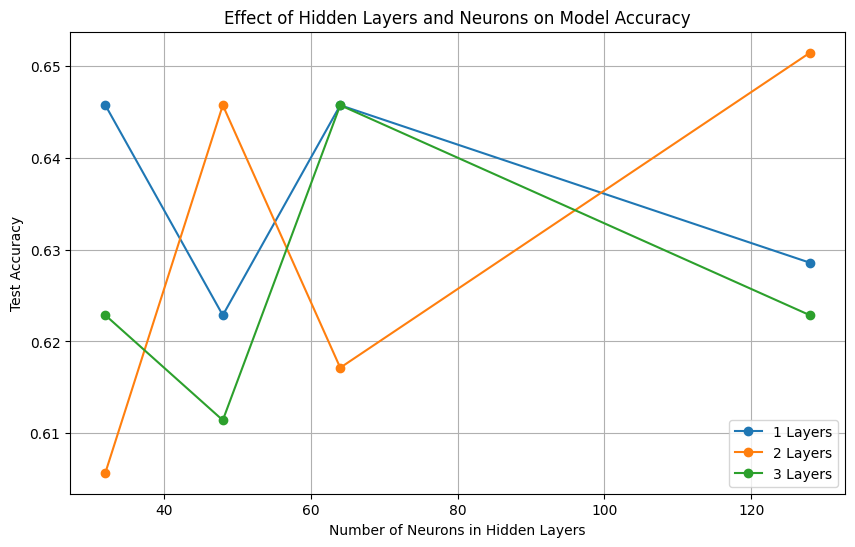

In [35]:
plt.figure(figsize=(10, 6))
for num_layers, results in accuracies_per_layers.items():
    neurons_vals, accuracies_vals = zip(*results)
    plt.plot(neurons_vals, accuracies_vals, label=f'{num_layers} Layers', marker='o')

plt.xlabel('Number of Neurons in Hidden Layers')
plt.ylabel('Test Accuracy')
plt.title('Effect of Hidden Layers and Neurons on Model Accuracy')
plt.legend()
plt.grid(True)
plt.savefig("analysis.pdf")
plt.show()

## Classification of the samples

In [36]:
test_predictions = best_model.predict(test_to_submit)

predicted_labels = np.argmax(test_predictions, axis=1)

submission = pd.DataFrame(predicted_labels, columns=['emotion'])

emotion_labels = list(y.columns)  
submission['emotion'] = submission['emotion'].map(lambda x: emotion_labels[x])

submission.to_csv('submission.csv', index=False)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
